In [2]:
import pandas as pd
ratings_data = pd.read_csv('/content/ratings.csv')
movies_data = pd.read_csv('/content/movies.csv')
# Merge the two datasets
movie_ratings_data = pd.merge(ratings_data, movies_data, on='movieId')


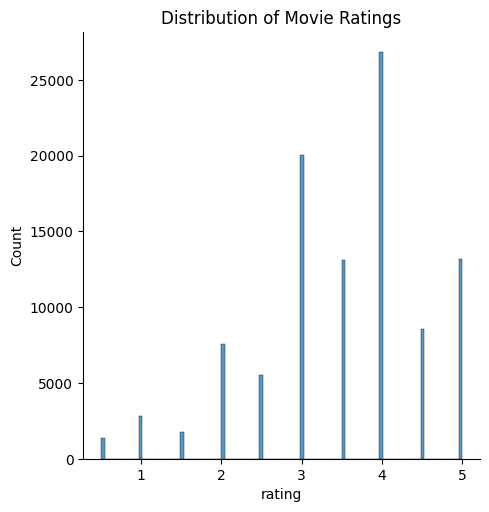

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot the distribution of movie ratings
sns.displot(movie_ratings_data ['rating'])
plt.title('Distribution of Movie Ratings')
plt.show()

In [19]:
!pip install surprise
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
import numpy as np
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split

# Load the dataset from the merged DataFrame
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(movie_ratings_data[['userId', 'movieId', 'rating']], reader)

# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

# Train the SVD model
algo = SVD()
algo.fit(trainset)

# Generate predictions for the test set
test_predictions = algo.test(testset)

# Calculate the overall RMSE and MAE
from surprise import accuracy
rmse = accuracy.rmse(test_predictions)
mae = accuracy.mae(test_predictions)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Get the top-n recommendations for a user
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions."""
    # First map the predictions to each user.
    top_n = {}
    for uid, iid, true_r, est, _ in predictions:
        if uid not in top_n:
            top_n[uid] = []
        top_n[uid].append((iid, est))

    # Then sort the recommendations for each user and retain the top-n items.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

# Get the top 10 recommendations for each user
top_n = get_top_n(test_predictions, n=10)

# Print the recommendations for a specific user
user_id = 196
print(f"Recommendations for user {user_id}:")
for iid, rating in top_n[user_id]:
    print(f"Movie ID {iid}: {rating:.2f}")

RMSE: 0.8794
MAE:  0.6741
RMSE: 0.8794
MAE: 0.6741
Recommendations for user 196:
Movie ID 58559: 4.23
Movie ID 364: 4.17
Movie ID 2762: 4.02
Movie ID 1259: 4.02
Movie ID 1214: 4.01
Movie ID 457: 4.00
Movie ID 1036: 3.97
Movie ID 4963: 3.82
Movie ID 104: 3.58
Movie ID 62: 3.49


In [15]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the data
data = pd.read_csv('movies.csv')

# Check if the data frame is empty
if data.empty:
    print("The 'movies.csv' file is empty.")
    exit()

# Create a genre list for each movie
data['genres'] = data[data.columns[2:]].apply(lambda x: '|'.join(x.dropna()), axis=1)

# Create a genre count vector
genre_vectorizer = CountVectorizer(token_pattern=r'(\w+)')
genre_matrix = genre_vectorizer.fit_transform(data['genres'])

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(genre_matrix, genre_matrix)

# Function to get the top n recommendations for a given movie
def get_recommendations(title, cosine_sim=cosine_sim, topn=10):
    # Get the index of the movie that matches the title
    try:
        idx = data[data['title'] == title].index[0]
    except IndexError:
        print(f"Movie '{title}' not found in the dataset.")
        return pd.DataFrame()

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the top n most similar movies
    sim_scores = sim_scores[1:topn+1]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top n most similar movies
    return data.iloc[movie_indices]

# Example usage
recommendations = get_recommendations('Toy Story (1995)')
print(recommendations)


      movieId                                              title  \
1706     2294                                        Antz (1998)   
2355     3114                                 Toy Story 2 (1999)   
2809     3754     Adventures of Rocky and Bullwinkle, The (2000)   
3000     4016                   Emperor's New Groove, The (2000)   
3568     4886                              Monsters, Inc. (2001)   
6194    45074                                   Wild, The (2006)   
6486    53121                             Shrek the Third (2007)   
6948    65577                     Tale of Despereaux, The (2008)   
7760    91355  Asterix and the Vikings (Astérix et les Viking...   
8219   103755                                       Turbo (2013)   

                                           genres  
1706  Adventure|Animation|Children|Comedy|Fantasy  
2355  Adventure|Animation|Children|Comedy|Fantasy  
2809  Adventure|Animation|Children|Comedy|Fantasy  
3000  Adventure|Animation|Children|Comedy|F